# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import chart_studio.plotly as ply
import cufflinks as cf

from statsmodels.tsa.vector_ar.vecm import coint_johansen

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['text.color'] = 'k'
plt.rcParams["figure.figsize"] = [12,9]

# Importing Data

In [143]:
data = pd.ExcelFile('Data//compiled_data.xlsx')
df = data.parse('Sheet1')

In [144]:
df.columns

Index(['date', 'cpi_ind', 'cpi_us', 'forex', 'iip_ind', 'iip_us', 'int_ind',
       'int_us', 'm1_ind_rs', 'm1_us_b', 'reserves_ind', 'reserves_us',
       'stocks_ind', 'stocks_us', 'trade_ind', 'trade_us'],
      dtype='object')

In [145]:
df['m1_ind'] = (df['m1_ind_rs'] / df['forex']) / 1000000000
df['m1_us'] = df['m1_us_b']

In [146]:
df['cpi_d'] = df['cpi_us'] - df['cpi_ind']
df['iip_d'] = df['iip_us'] - df['iip_ind']
df['int_d'] = df['int_us'] - df['int_ind']
df['m1_d'] = df['m1_us_b'] - df['m1_ind']
df['rsrv_d'] = df['reserves_us'] - df['reserves_ind']
df['stock_d'] = df['stocks_us'] - df['stocks_ind']
df['trade_d'] = df['trade_us'] - df['trade_ind']



In [147]:
import datetime as dt

df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year


In [148]:
df_d = df[['forex', 'cpi_d', 'iip_d', 'int_d', 'm1_d', 'rsrv_d', 'stock_d', 'trade_d']]

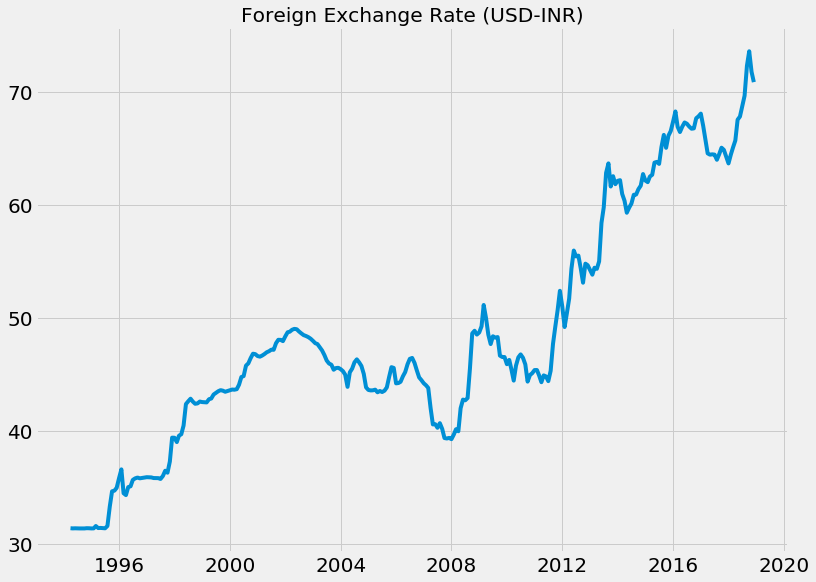

In [555]:
y = df['forex']

plt.plot(df['date'], y)
plt.title('Foreign Exchange Rate (USD-INR)')
#plt.show()
plt.savefig('forex.png')

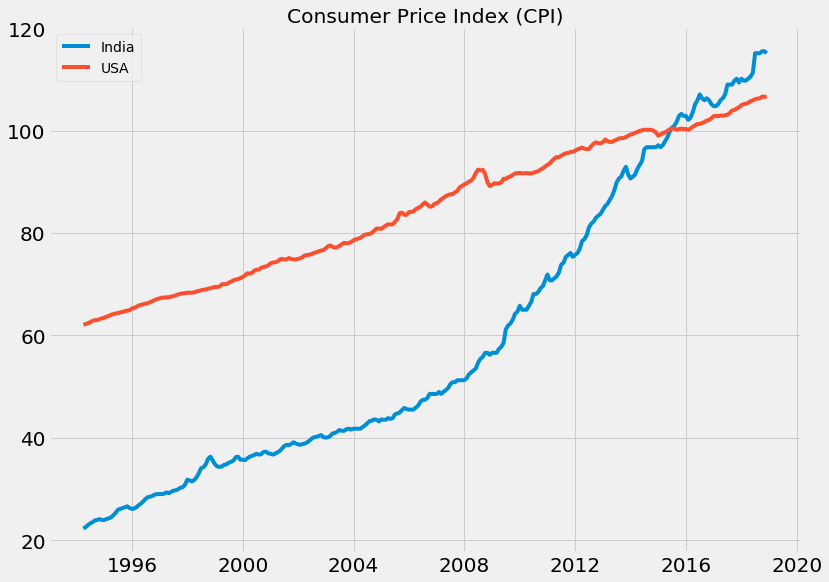

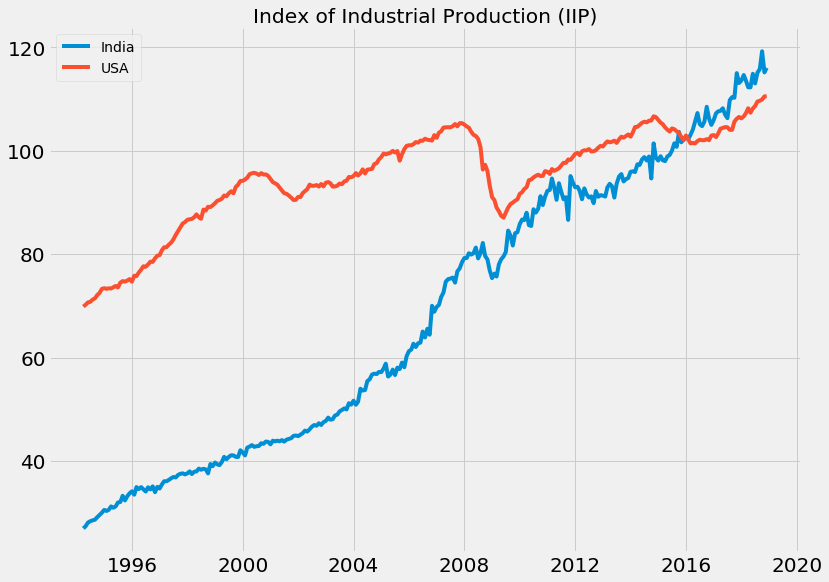

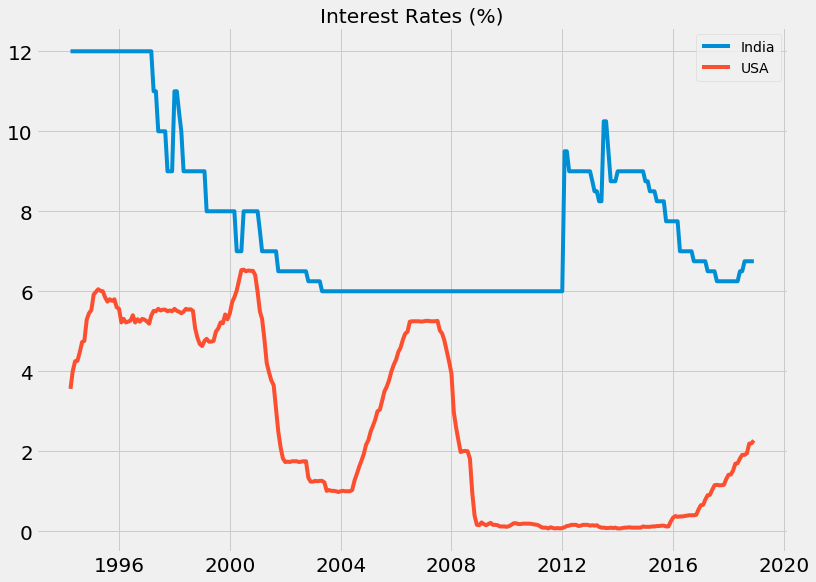

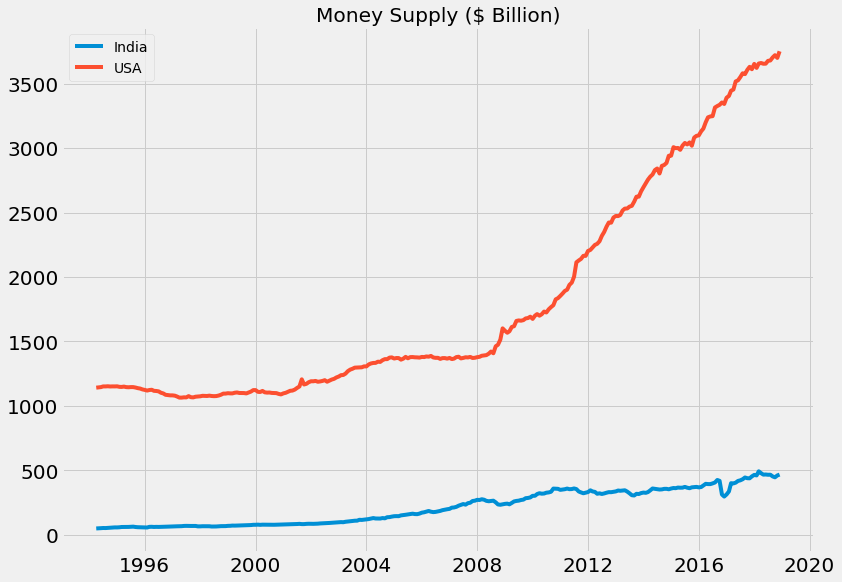

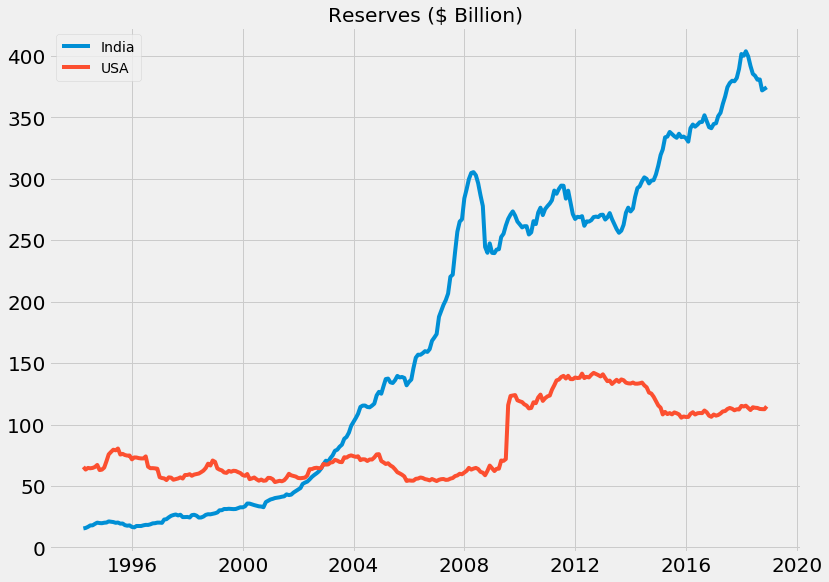

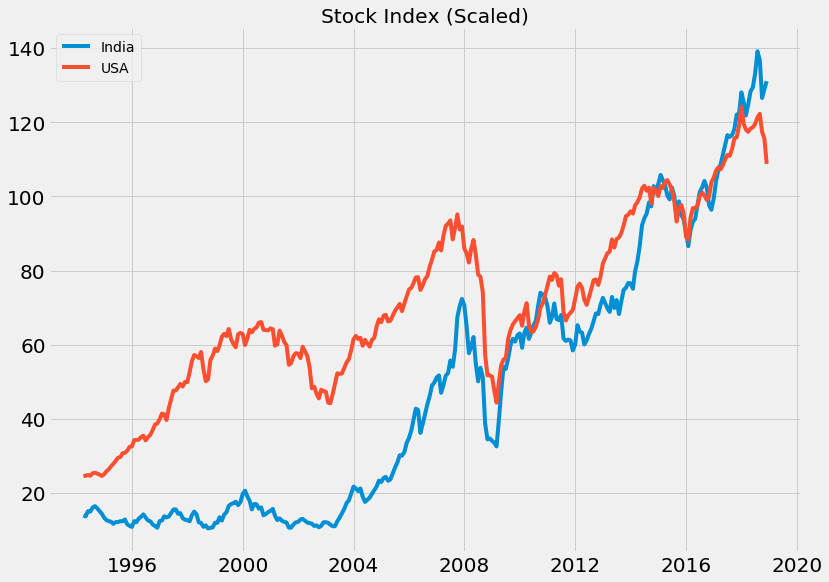

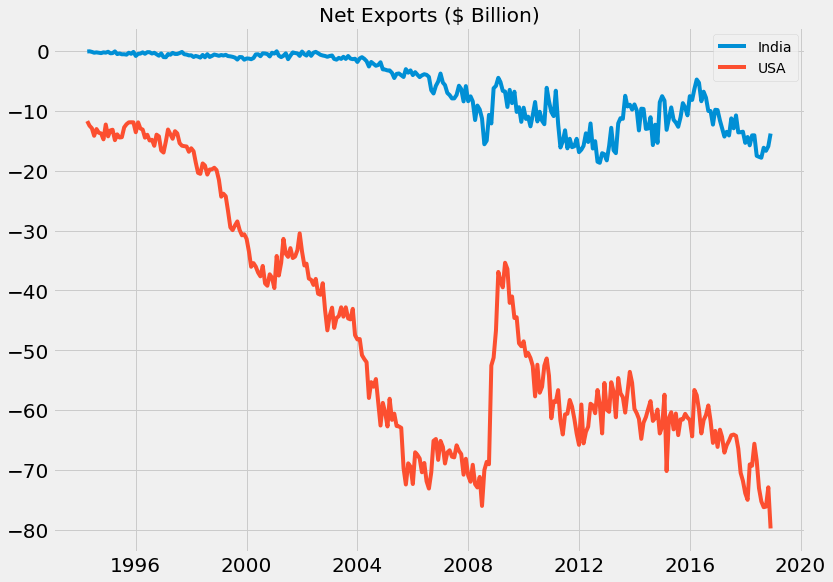

In [553]:
for params in ['cpi_', 'iip_', 'int_', 'm1_', 'reserves_', 'stocks_', 'trade_']:
        
    if params in ['reserves_', 'trade_']:
        plt.plot(df['date'], df[params+'ind']/1000000000, label='India')
        plt.plot(df['date'], df[params+'us']/1000000000, label='USA')
    else:
        plt.plot(df['date'], df[params+'ind'], label='India')
        plt.plot(df['date'], df[params+'us'], label='USA')
        
    if params == 'cpi_':
        plt.title('Consumer Price Index (CPI)')
    elif params == 'iip_':
        plt.title('Index of Industrial Production (IIP)')
    elif params == 'int_':
        plt.title('Interest Rates (%)')
    elif params == 'm1_':
        plt.title('Money Supply ($ Billion)')
    elif params == 'reserves_':
        plt.title('Reserves ($ Billion)')
    elif params == 'stocks_':
        plt.title('Stock Index (Scaled)')
    elif params == 'trade_':
        plt.title('Net Exports ($ Billion)')
    plt.legend()
    plt.savefig(params + '.png')
    plt.show()

# Data Transformation

In [78]:
#creating the train and validation set
train = df_d[:int(0.8*(len(df_d)))]
valid = df_d[int(0.8*(len(df_d))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

In [85]:
from sklearn.metrics import mean_squared_error

#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[df_d.columns])
for j in range(0,len(df_d.columns)):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in df_d.columns:
    print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(pred[i], valid[i])))

rmse value for forex is :  24.323693390058363
rmse value for cpi_d is :  19.466186916850354
rmse value for iip_d is :  14.717798345921514
rmse value for int_d is :  9.17150129641354
rmse value for m1_d is :  622.4990911313656
rmse value for rsrv_d is :  270732668525.31985
rmse value for stock_d is :  33.818022748422656
rmse value for trade_d is :  34319661879.267124
rmse value for month is :  5.141939727068482
rmse value for year is :  0.4284943770987232


In [99]:
coint_johansen(df_d,-1,1).eig

array([3.56380857e-01, 1.40173620e-01, 1.13413545e-01, 9.37700892e-02,
       5.42725404e-02, 2.56075444e-02, 2.02781357e-02, 2.50277669e-05])

# Blog

In [19]:
input_feature= df_d.iloc[:,:].values
input_data = input_feature

In [22]:
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,:] = sc.fit_transform(input_feature[:,:])

In [238]:
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_data = sc.fit_transform(df_d)

In [88]:
lookback= 3

test_size=int(.2 * len(df_d))
X=[]
y=[]
for i in range(len(df_d)-lookback-1):
    t=[]
    for j in range(0,lookback):
        
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,0])

In [89]:
X, y= np.array(X), np.array(y)
X_test = X[-(test_size+lookback):]
X = X.reshape(X.shape[0],lookback, 8)
X_test = X_test.reshape(X_test.shape[0],lookback, 8)
print(X.shape)
print(X_test.shape)

(293, 3, 8)
(62, 3, 8)


In [571]:
from keras import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

In [572]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],8)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 2, 30)             4680      
_________________________________________________________________
lstm_38 (LSTM)               (None, 2, 30)             7320      
_________________________________________________________________
lstm_39 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 31        
Total params: 19,351
Trainable params: 19,351
Non-trainable params: 0
_________________________________________________________________


In [92]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [93]:
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

In [94]:
hist = model.fit(X[:], y[:], epochs=50, batch_size=32, validation_split = 0.0, callbacks = [early])

Epoch 1/50
293/293 [==============================] - 7s 25ms/step - loss: 0.2037
Epoch 2/50
293/293 [==============================] - 0s 589us/step - loss: 0.1468
Epoch 3/50
293/293 [==============================] - 0s 377us/step - loss: 0.0908
Epoch 4/50
293/293 [==============================] - 0s 373us/step - loss: 0.0717
Epoch 5/50
293/293 [==============================] - 0s 648us/step - loss: 0.0500
Epoch 6/50
293/293 [==============================] - 0s 684us/step - loss: 0.0274
Epoch 7/50
293/293 [==============================] - 0s 719us/step - loss: 0.0073
Epoch 8/50
293/293 [==============================] - 0s 693us/step - loss: 0.0069
Epoch 9/50
293/293 [==============================] - 0s 671us/step - loss: 0.0048
Epoch 10/50
293/293 [==============================] - 0s 654us/step - loss: 0.0043
Epoch 11/50
293/293 [==============================] - 0s 663us/step - loss: 0.0038
Epoch 12/50
293/293 [==============================] - 0s 668us/step - loss: 0.0035
Ep

In [95]:
predicted_value= model.predict(X_test)

In [570]:
model.summary()

AttributeError: 'VAR' object has no attribute 'summary'

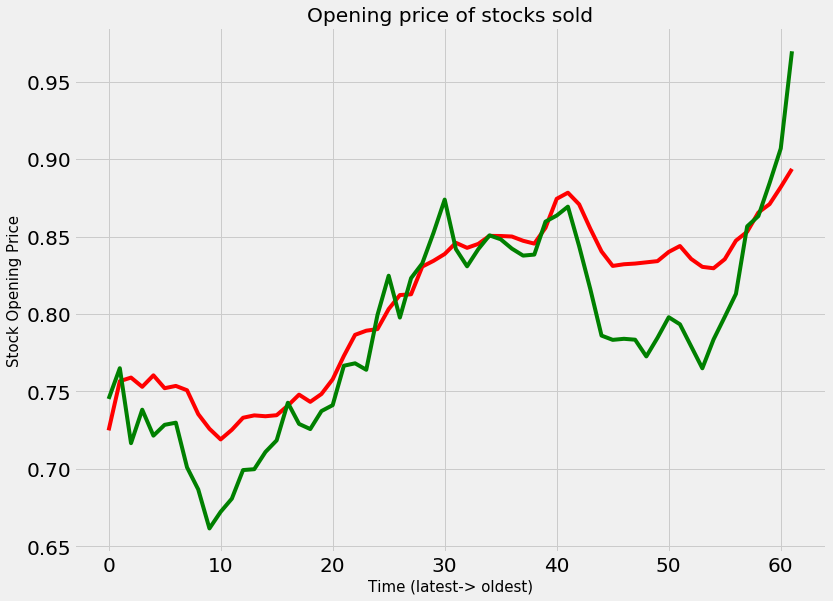

In [674]:
plt.plot(predicted_value, color= 'red')
plt.plot(input_data[-(test_size+(2*lookback)):-lookback,0], color='green')
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()

In [63]:
copy_in = input_data.copy()

# Another Try

In [161]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping


IndexError: index 8 is out of bounds for axis 1 with size 8

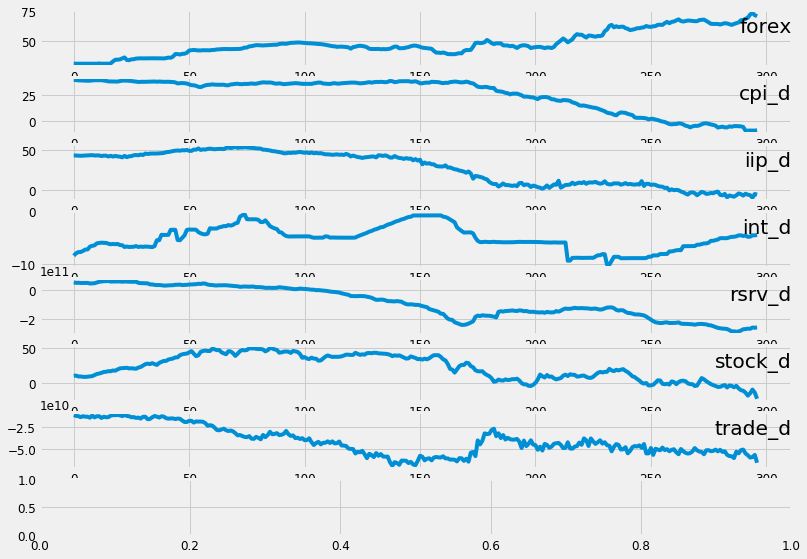

In [150]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = df_d.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7, 8]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df_d.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [753]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = df_d.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000453   1.000000   0.833145   0.178351   0.041750   0.970827   
2   0.000073   0.997496   0.831873   0.224742   0.042352   0.963546   
3   0.000289   0.992458   0.827775   0.249484   0.042621   0.964742   
4   0.000097   0.989984   0.825485   0.250515   0.044461   0.960586   
5   0.000009   0.990074   0.829499   0.272165   0.044590   0.961125   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.450665   0.996646  0.000073  
2   0.456269   0.982934  0.000289  
3   0.439480   0.977204  0.000097  
4   0.438316   0.957850  0.000009  
5   0.432479   0.976201  0.000000  


In [769]:
# split into train and test sets
values = reframed.values
n_train_hours = int(0.9*len(df_d))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(267, 1, 8) (267,) (29, 1, 8) (29,)


Train on 267 samples, validate on 29 samples
Epoch 1/100
 - 11s - loss: 0.3595 - val_loss: 0.7771
Epoch 2/100
 - 0s - loss: 0.3226 - val_loss: 0.7514
Epoch 3/100
 - 0s - loss: 0.2870 - val_loss: 0.7260
Epoch 4/100
 - 0s - loss: 0.2561 - val_loss: 0.7006
Epoch 5/100
 - 0s - loss: 0.2269 - val_loss: 0.6756
Epoch 6/100
 - 0s - loss: 0.2046 - val_loss: 0.6515
Epoch 7/100
 - 0s - loss: 0.1847 - val_loss: 0.6283
Epoch 8/100
 - 0s - loss: 0.1685 - val_loss: 0.6057
Epoch 9/100
 - 0s - loss: 0.1576 - val_loss: 0.5854
Epoch 10/100
 - 0s - loss: 0.1527 - val_loss: 0.5675
Epoch 11/100
 - 0s - loss: 0.1510 - val_loss: 0.5521
Epoch 12/100
 - 0s - loss: 0.1512 - val_loss: 0.5398
Epoch 13/100
 - 0s - loss: 0.1512 - val_loss: 0.5303
Epoch 14/100
 - 0s - loss: 0.1499 - val_loss: 0.5227
Epoch 15/100
 - 0s - loss: 0.1475 - val_loss: 0.5164
Epoch 16/100
 - 0s - loss: 0.1445 - val_loss: 0.5103
Epoch 17/100
 - 0s - loss: 0.1416 - val_loss: 0.5036
Epoch 18/100
 - 0s - loss: 0.1390 - val_loss: 0.4957
Epoch 19/

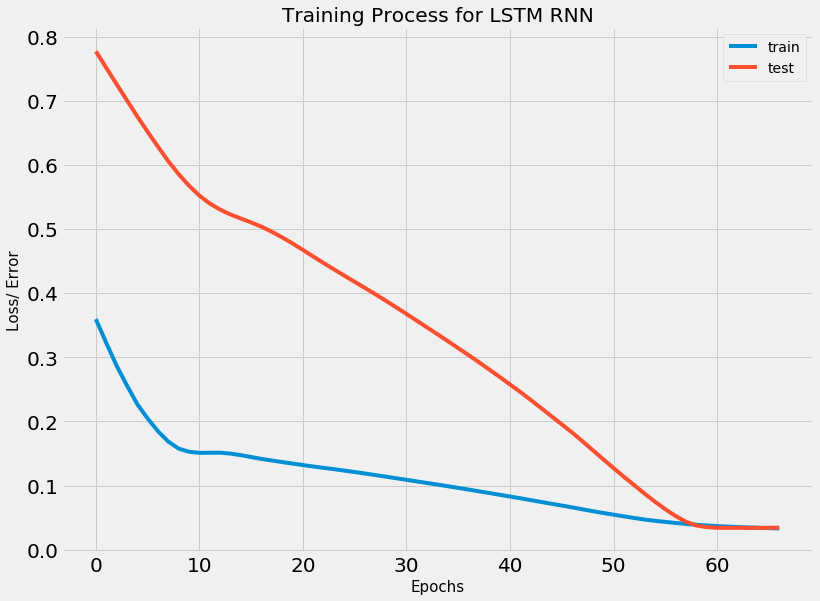

In [771]:
# design network
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dense(4))
model.add(Dense(1))
#model.add(Dropout(0.2))
model.compile(loss='mae', optimizer='adam')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[early])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.title('Training Process for LSTM RNN')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss/ Error')
pyplot.savefig('LSTM_Training.png')

In [767]:
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.687


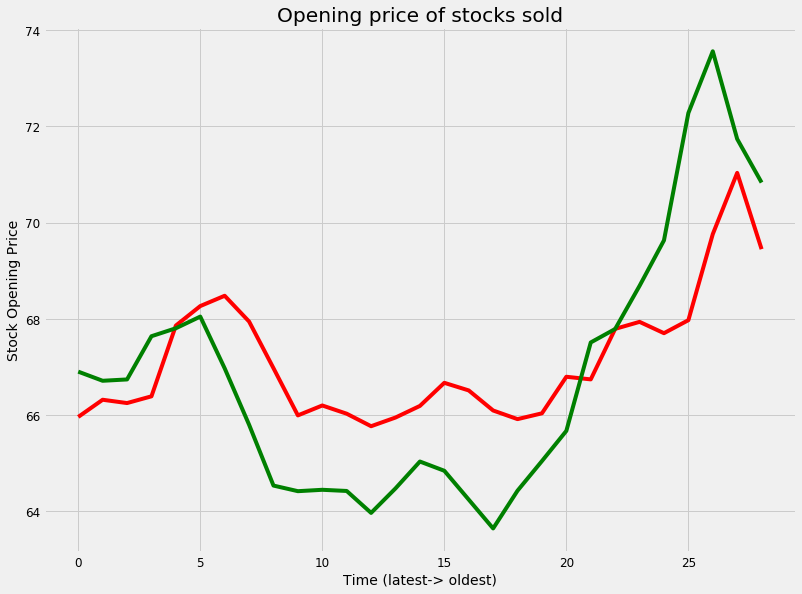

In [224]:
plt.plot(inv_yhat, color= 'red')
plt.plot(inv_y, color='green')
plt.title("Predictions by LSTM Model")
plt.xlabel("Months (August 2016-> December 2018)")
plt.ylabel("USD/INR Exchange Rate")
plt.show()

In [445]:
accuracy = 100 - (np.mean(abs(inv_y - inv_yhat)/inv_y))*100
print('Accuracy= '+ str(accuracy)+ ' %')

Accuracy= 97.8066174313426 %


# SVM Model

In [743]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.000453,1.000000,0.833145,0.178351,0.041750,0.970827,0.450665,0.996646,0.000073
2,0.000073,0.997496,0.831873,0.224742,0.042352,0.963546,0.456269,0.982934,0.000289
3,0.000289,0.992458,0.827775,0.249484,0.042621,0.964742,0.439480,0.977204,0.000097
4,0.000097,0.989984,0.825485,0.250515,0.044461,0.960586,0.438316,0.957850,0.000009
5,0.000009,0.990074,0.829499,0.272165,0.044590,0.961125,0.432479,0.976201,0.000000
6,0.000000,0.985870,0.831762,0.298969,0.044505,0.960018,0.429339,0.966656,0.000007
7,0.000007,0.985036,0.833708,0.302062,0.043078,0.961877,0.434122,0.965820,0.000514
8,0.000514,0.985096,0.833665,0.356701,0.042946,0.950943,0.441035,0.946537,0.000405
9,0.000405,0.991089,0.839225,0.373196,0.042405,0.952211,0.445325,0.990126,0.000031
10,0.000031,0.994548,0.832486,0.381443,0.042786,0.955970,0.466936,0.953465,0.000171


In [635]:
# split into train and test sets
values = reframed.values
n_train_hours = int(0.9*len(df_d))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [636]:
train_X.shape

(267, 8)

In [637]:
from sklearn.svm import SVR
import numpy as np

clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
clf.fit(train_X, train_y) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [638]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(train_X, train_y) 

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=-4.281158223419654, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=-1.1075209376945372, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=-2.4129259775781944, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=-0.9843032621358083, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=-0.9877676069969813, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=-1.9438003093391876, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf .......................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.0s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [639]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [640]:
grid_predictions = grid.predict(test_X)

In [641]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: forex')
accuracy_prod = forecast_accuracy(grid_predictions, test_y)
for k, v in accuracy_prod.items():
    print(str(k), ': ', round(v,4))


Forecast Accuracy of: forex
mape :  0.0522
me :  -0.0428
mae :  0.0462
mpe :  -0.0477
rmse :  0.0606
corr :  0.8647
minmax :  0.0521


In [671]:
grid_predictions = grid_predictions.reshape((29,1))

In [672]:
from sklearn.metrics import mean_squared_error

# make a prediction
#yhat = model.predict(test_X)
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_pred_svm = np.concatenate((grid_predictions, test_X[:, 1:]), axis=1)
inv_pred_svm = scaler.inverse_transform(inv_pred_svm)
inv_pred_svm = inv_pred_svm[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_pred_svm))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.558


In [742]:
train_X

array([[4.52756882e-04, 1.00000000e+00, 8.33144784e-01, ...,
        9.70826983e-01, 4.50665057e-01, 9.96646464e-01],
       [7.34925270e-05, 9.97495949e-01, 8.31873000e-01, ...,
        9.63546157e-01, 4.56268936e-01, 9.82934415e-01],
       [2.89201736e-04, 9.92457747e-01, 8.27774525e-01, ...,
        9.64741528e-01, 4.39480186e-01, 9.77204323e-01],
       ...,
       [8.30783665e-01, 1.24779597e-01, 1.07446894e-01, ...,
        1.55656040e-01, 3.56510013e-01, 2.87162185e-01],
       [8.41867387e-01, 9.89271924e-02, 8.15012753e-02, ...,
        1.55359924e-01, 3.45633626e-01, 2.54843771e-01],
       [8.50779712e-01, 8.93258750e-02, 6.22303337e-02, ...,
        1.53587699e-01, 3.03738147e-01, 2.39661276e-01]], dtype=float32)

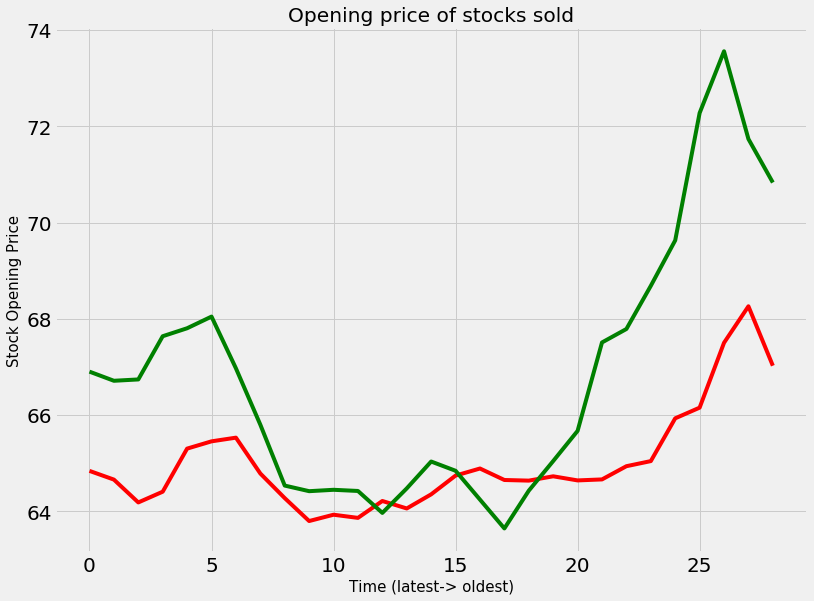

In [673]:
plt.plot(inv_pred_svm, color= 'red')
plt.plot(inv_y, color='green')
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()

In [595]:
from sklearn.ensemble import ExtraTreesRegressor
#from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
#iris = load_iris()
X, y = train_X, train_y
#X.shape

clf = ExtraTreesRegressor(n_estimators=50)
clf = clf.fit(X, y)
print(clf.feature_importances_)

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape 

[0.36710801 0.20966212 0.03743884 0.01246653 0.2789747  0.02427815
 0.00575794 0.0643137 ]


(267, 3)

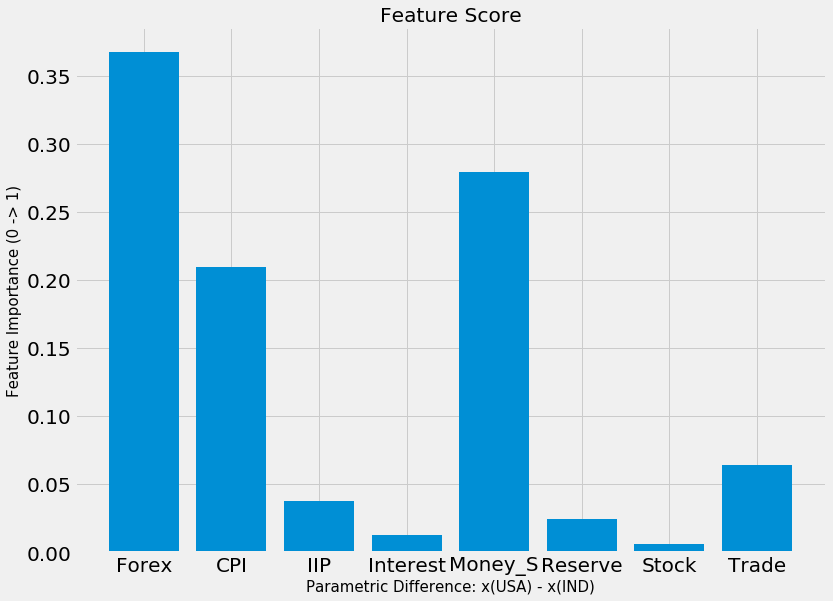

In [596]:
x = ('Forex', 'CPI', 'IIP', 'Interest', 'Money_S', 'Reserve', 'Stock', 'Trade')
y = clf.feature_importances_

plt.bar(x,y,align='center') # A bar chart
plt.xlabel('Parametric Difference: x(USA) - x(IND)')
plt.ylabel('Feature Importance (0 -> 1)')
plt.title('Feature Score')
#plt.show()
plt.savefig('ft_score.png')

In [446]:
accuracy = 100 - (np.mean(abs(inv_y - inv_pred_svm)/inv_y))*100
print('Accuracy= '+ str(accuracy)+ ' %')

Accuracy= 97.16691983952242 %


In [ ]:
# Simple MLP

# VAR

In [225]:
#checking stationarity

from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
johan_test_temp = df_d
coint_johansen(johan_test_temp,-1,1).eig

array([3.56380857e-01, 1.40173620e-01, 1.13413545e-01, 9.37700892e-02,
       5.42725404e-02, 2.56075444e-02, 2.02781357e-02, 2.50277669e-05])

In [231]:
#creating the train and validation set
train = df_d[:-int(0.1*(len(df_d)))]
valid = df_d[-int(0.1*(len(df_d))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

In [250]:
preds = prediction[:,0]

In [253]:
rmse_var = np.sqrt(mean_squared_error(inv_y, preds))
print('Test RMSE: %.3f' % rmse_var)

Test RMSE: 6.216


# Another VAR

In [646]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_d, variables = df_d.columns)  

,forex_x,cpi_d_x,iip_d_x,int_d_x,m1_d_x,rsrv_d_x,stock_d_x,trade_d_x
forex_y,1.0000,0.0000,0.0004,0.0985,0.0088,0.0205,0.0186,0.0234
cpi_d_y,0.0018,1.0000,0.0001,0.0046,0.0026,0.0000,0.0000,0.1888
iip_d_y,0.3477,0.1776,1.0000,0.0623,0.1061,0.0000,0.0118,0.0001
int_d_y,0.2085,0.2547,0.0000,1.0000,0.0067,0.0417,0.2335,0.1241
m1_d_y,0.0768,0.0000,0.0000,0.0027,1.0000,0.0020,0.0009,0.0198
rsrv_d_y,0.0000,0.0023,0.0078,0.1276,0.0265,1.0000,0.0171,0.0000
stock_d_y,0.0053,0.0423,0.0000,0.0057,0.0095,0.0002,1.0000,0.0073
trade_d_y,0.0283,0.0057,0.0131,0.0352,0.0401,0.0568,0.1488,1.0000


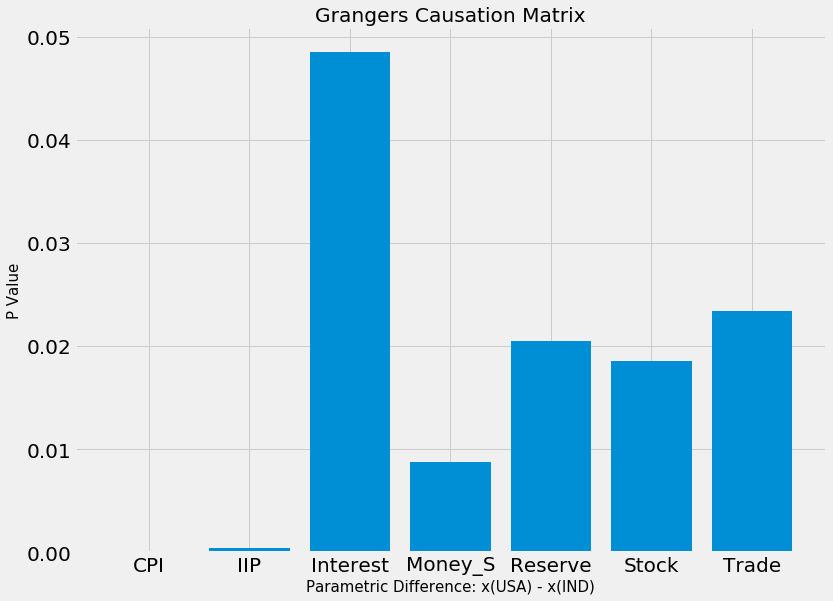

In [647]:
import matplotlib.pyplot as plt

x = ('CPI', 'IIP', 'Interest', 'Money_S', 'Reserve', 'Stock', 'Trade')
y = (0.0001, 0.0004, 0.0485, 0.0088, 0.0205, 0.0186, 0.0234)

plt.bar(x,y,align='center') # A bar chart
plt.xlabel('Parametric Difference: x(USA) - x(IND)')
plt.ylabel('P Value')
plt.title('Grangers Causation Matrix')
#plt.show()
plt.savefig('Grangers.png')

In [648]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    #print(coint_johansen(df,-1,5).eig)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_d)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
forex  ::  247.72    > 143.6691  =>   True
cpi_d  ::  145.29    > 111.7797  =>   True
iip_d  ::  94.28     > 83.9383   =>   True
int_d  ::  56.2      > 60.0627   =>   False
m1_d   ::  33.58     > 40.1749   =>   False
rsrv_d ::  14.72     > 24.2761   =>   False
stock_d ::  6.22      > 12.3212   =>   False
trade_d ::  0.14      > 4.1296    =>   False


In [649]:
nobs = int(0.1*len(df_d))
df_train, df_test = df_d[0:-nobs], df_d[-nobs:]

# Check size
print(df_train.shape)  # (268, 8)
print(df_test.shape)  # (29, 8)

(268, 8)
(29, 8)


In [650]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [651]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "forex" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.5258
 No. Lags Chosen       = 5
 Critical value 1%     = -3.456
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.8869. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "cpi_d" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.0304
 No. Lags Chosen       = 15
 Critical value 1%     = -3.457
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.9946. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "iip_d" 
    -----------------------------------------------
 Null Hypothesis: Data has unit

In [652]:
# 1st difference
df_differenced = df_train.diff().dropna()


In [653]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "forex" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.0766
 No. Lags Chosen       = 4
 Critical value 1%     = -3.456
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "cpi_d" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5259
 No. Lags Chosen       = 14
 Critical value 1%     = -3.457
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.5207. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "iip_d" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 

In [654]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  91.69377755090744
BIC :  92.66374647659272
FPE :  6.64035644054022e+39
HQIC:  92.0834519225938 

Lag Order = 2
AIC :  91.78267093064478
BIC :  93.61981529416978
FPE :  7.266420524096127e+39
HQIC:  92.52080744795573 

Lag Order = 3
AIC :  91.68963197880565
BIC :  94.39868432967407
FPE :  6.641693169131776e+39
HQIC:  92.77821159331074 

Lag Order = 4
AIC :  91.82947233053785
BIC :  95.41520869743873
FPE :  7.685153142432817e+39
HQIC:  93.2704941455063 

Lag Order = 5
AIC :  92.03743548620818
BIC :  96.50467593366481
FPE :  9.55783175510575e+39
HQIC:  93.83291698369017 

Lag Order = 6
AIC :  92.08376385257571
BIC :  97.43737304671554
FPE :  1.0165523953795927e+40
HQIC:  94.23574112405893 

Lag Order = 7
AIC :  92.04858954827269
BIC :  98.29347733189992
FPE :  1.0030645657123083e+40
HQIC:  94.55911752898136 

Lag Order = 8
AIC :  92.01105020668001
BIC :  99.15217218383738
FPE :  9.952964219390558e+39
HQIC:  94.88220291358515 

Lag Order = 9
AIC :  92.00141045147734
BIC

In [655]:
x = model.select_order(maxlags=9)
x.summary()

,AIC,BIC,FPE,HQIC
0,92.70,92.81*,1.824e+40,92.75
1,91.92,92.91,8.288e+39,92.31*
2,91.99,93.86,8.938e+39,92.74
3,91.88*,94.63,7.997e+39*,92.98
4,91.99,95.63,9.059e+39,93.46
5,92.17,96.69,1.095e+40,93.99
6,92.19,97.58,1.127e+40,94.36
7,92.12,98.40,1.075e+40,94.64
8,92.05,99.21,1.039e+40,94.93
9,92.00,100.0,1.025e+40,95.24


In [717]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 01, Dec, 2019
Time:                     16:50:26
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    94.3987
Nobs:                     264.000    HQIC:                   92.7782
Log likelihood:          -14899.8    FPE:                6.64169e+39
AIC:                      91.6896    Det(Omega_mle):     3.22053e+39
--------------------------------------------------------------------
Results for equation forex
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.058736         0.059643            0.985           0.325
L1.forex           0.320917         0.066910            4.796           0.000
L1.cpi_d          -0.174404         0.097946           -1.781           

In [718]:
# Durbib-Watson Test
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_d.columns, out):
    print(str(col), ':', round(val, 2))

forex : 1.99
cpi_d : 1.96
iip_d : 2.01
int_d : 1.98
m1_d : 1.99
rsrv_d : 2.04
stock_d : 1.97
trade_d : 1.99


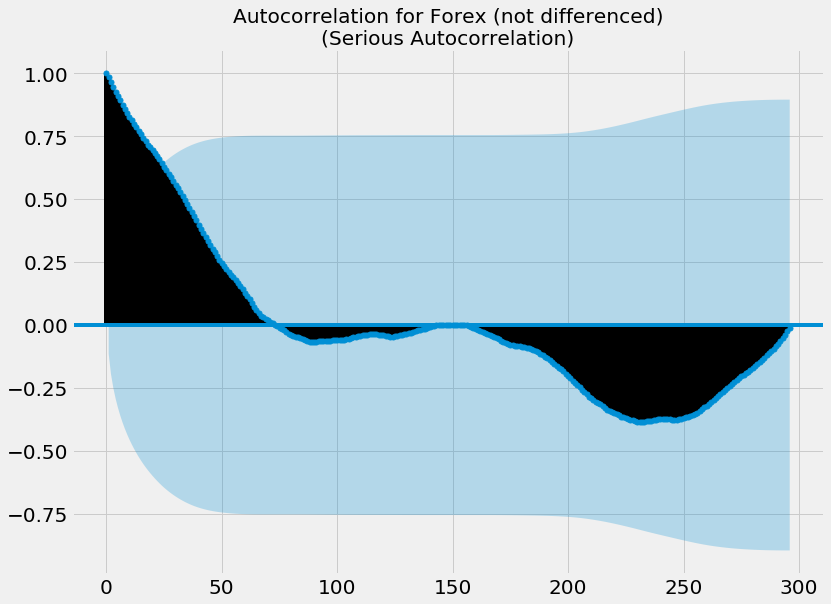

In [750]:
plot_acf(df_d['forex'])
pyplot.title("Autocorrelation for Forex (not differenced)\n(Serious Autocorrelation)")
pyplot.savefig('DWTest_1.png')

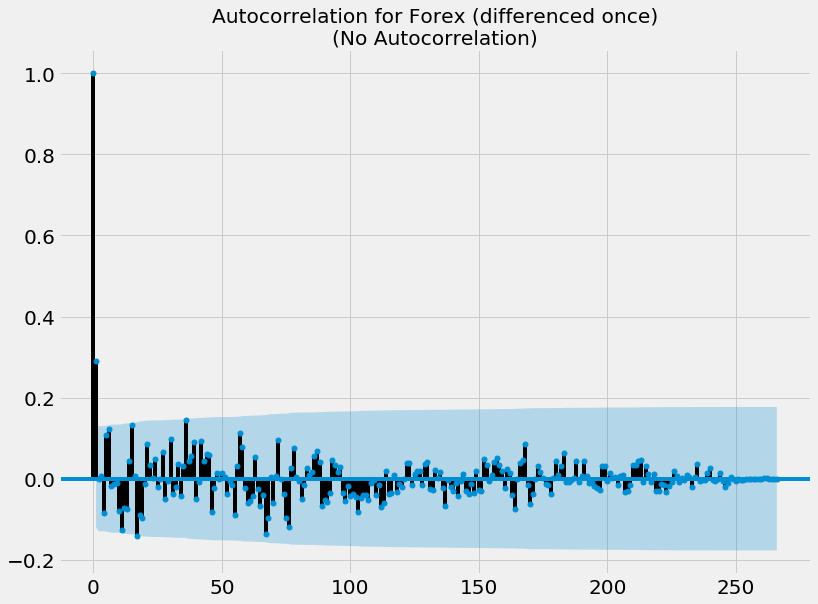

In [751]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
#series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0)
plot_acf(df_differenced['forex'])
pyplot.title("Autocorrelation for Forex (differenced once)\n(No Autocorrelation)")
pyplot.savefig('DWTest.png')

In [720]:
df_differenced.columns

Index(['forex', 'cpi_d', 'iip_d', 'int_d', 'm1_d', 'rsrv_d', 'stock_d',
       'trade_d'],
      dtype='object')

In [721]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

3


array([[ 4.67600000e-01, -1.26136723e+00, -1.62658609e+00,
         0.00000000e+00,  4.04468340e+01, -1.03263927e+08,
        -7.93167884e-01, -1.87429613e+09],
       [ 3.76000000e-01, -4.68458964e-01, -1.20813701e+00,
         1.00000000e-02,  7.04044854e+00, -6.17895551e+08,
        -3.05525200e+00, -8.80497910e+08],
       [-1.07500000e-01, -1.15476572e+00,  2.40849848e+00,
         1.00000000e-02, -3.27520108e+00, -1.77323864e+09,
        -1.06982747e+00,  6.23058192e+08]])

In [722]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_d.index[-nobs:], columns=df_d.columns + '_2d')
df_forecast.head()

,forex_2d,cpi_d_2d,iip_d_2d,int_d_2d,m1_d_2d,rsrv_d_2d,stock_d_2d,trade_d_2d
268,-0.266673,-0.433493,-1.126822,-0.258765,18.056409,-2.871079e+09,-0.552085,2.332615e+09
269,0.256041,-0.066003,-0.585972,-0.064598,6.172885,-3.036940e+09,-0.112882,-2.028722e+09
270,0.145596,-0.148398,0.461526,0.203435,0.201346,-8.766910e+08,-0.482290,-5.495008e+08
271,-0.038725,-0.179651,-0.561312,-0.057481,7.997528,-2.272072e+09,-0.406090,1.257815e+09
272,0.155385,-0.142268,-0.134592,-0.018246,6.181611,-2.201120e+09,-0.013576,-9.024912e+08


In [723]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_2d'].cumsum()
    return df_fc

In [724]:
df_train.columns

Index(['forex', 'cpi_d', 'iip_d', 'int_d', 'm1_d', 'rsrv_d', 'stock_d',
       'trade_d'],
      dtype='object')

In [725]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)        
df_results.loc[:, ['forex_forecast', 'cpi_d_forecast', 'iip_d_forecast', 'int_d_forecast', 'm1_d_forecast', 'rsrv_d_forecast',
       'stock_d_forecast', 'trade_d_forecast']]


,forex_forecast,cpi_d_forecast,iip_d_forecast,int_d_forecast,m1_d_forecast,rsrv_d_forecast,stock_d_forecast,trade_d_forecast
268,66.891327,-6.220350,-4.141018,-6.868765,2867.723802,-2.395127e+11,-1.760879,-5.258374e+10
269,67.147369,-6.286352,-4.726990,-6.933363,2873.896687,-2.425496e+11,-1.873761,-5.461247e+10
270,67.292965,-6.434750,-4.265464,-6.729928,2874.098033,-2.434263e+11,-2.356051,-5.516197e+10
271,67.254240,-6.614401,-4.826776,-6.787409,2882.095561,-2.456984e+11,-2.762141,-5.390415e+10
272,67.409625,-6.756669,-4.961368,-6.805655,2888.277172,-2.478995e+11,-2.775716,-5.480664e+10
273,67.499893,-6.915560,-5.112968,-6.764193,2892.417593,-2.489597e+11,-2.851015,-5.513130e+10
274,67.576243,-7.066642,-5.451947,-6.777504,2898.678404,-2.505414e+11,-2.934922,-5.480863e+10
275,67.711834,-7.222513,-5.548533,-6.766010,2905.186501,-2.520496e+11,-3.017119,-5.529240e+10
276,67.820514,-7.399960,-5.741658,-6.762180,2910.799212,-2.531842e+11,-3.116172,-5.541079e+10
277,67.949606,-7.563931,-5.975184,-6.765428,2917.269974,-2.544565e+11,-3.154810,-5.543616e+10


In [726]:
preds_ = df_results['forex_forecast']

In [727]:
rmse_var_ = np.sqrt(mean_squared_error(inv_y, preds_))
print('Test RMSE: %.3f' % rmse_var_)

Test RMSE: 2.938


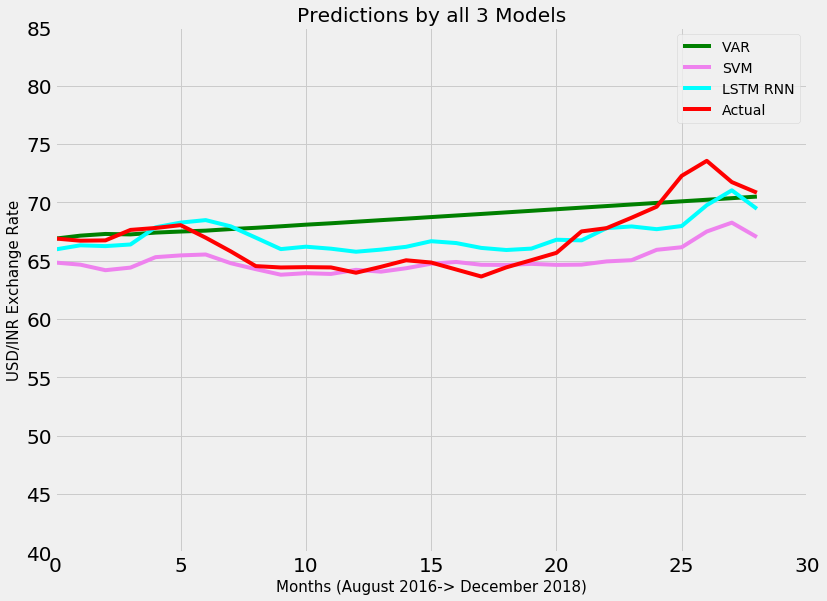

In [728]:
axes = plt.gca()
axes.set_xlim([0,30])
axes.set_ylim([40,85])
plt.plot(list(preds_), color= 'green', label = 'VAR')
plt.plot(inv_pred_svm, color= 'violet', label = 'SVM')
plt.plot(inv_yhat, color= 'cyan', label = 'LSTM RNN')

plt.plot(inv_y, color='red', label = 'Actual')
plt.title("Predictions by all 3 Models")
plt.xlabel("Months (August 2016-> December 2018)")
plt.ylabel("USD/INR Exchange Rate")
plt.legend()
#plt.show()
plt.savefig('performance.png')

In [768]:
from statsmodels.tsa.stattools import acf
from sklearn.metrics import r2_score
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    r2 = r2_score(actual, forecast)
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax, 'r2_score': r2})

print('For VAR')
accuracy_prod = forecast_accuracy(df_results['forex_forecast'], inv_y)
for k, v in accuracy_prod.items():
    print(str(k), ': ', round(v,4))
    
print('\n')
print('For SVM')
accuracy_prod = forecast_accuracy(inv_pred_svm, inv_y)
for k, v in accuracy_prod.items():
    print(str(k), ': ', round(v,4))
    

print('\n')
print('For LSTM RNN')
accuracy_prod = forecast_accuracy(inv_yhat, inv_y)
for k, v in accuracy_prod.items():
    print(str(k), ': ', round(v,4))
# print('\nForecast Accuracy of: cpi_d')
# accuracy_prod = forecast_accuracy(df_results['cpi_d_forecast'].values, df_test['cpi_d'])
# for k, v in accuracy_prod.items():
#     print(str(k), ': ', round(v,4))

# print('\nForecast Accuracy of: iip_d')
# accuracy_prod = forecast_accuracy(df_results['iip_d_forecast'].values, df_test['iip_d'])
# for k, v in accuracy_prod.items():
#     print(str(k), ': ', round(v,4))

# print('\nForecast Accuracy of: int_d')
# accuracy_prod = forecast_accuracy(df_results['int_d_forecast'].values, df_test['int_d'])
# for k, v in accuracy_prod.items():
#     print(str(k), ': ', round(v,4))

# print('\nForecast Accuracy of: m1_d')
# accuracy_prod = forecast_accuracy(df_results['m1_d_forecast'].values, df_test['m1_d'])
# for k, v in accuracy_prod.items():
#     print(str(k), ': ', round(v,4))

# print('\nForecast Accuracy of: rsrv_d')
# accuracy_prod = forecast_accuracy(df_results['rsrv_d_forecast'].values, df_test['rsrv_d'])
# for k, v in accuracy_prod.items():
#     print(str(k), ': ', round(v,4))

# print('\nForecast Accuracy of: stock_d')
# accuracy_prod = forecast_accuracy(df_results['stock_d_forecast'].values, df_test['stock_d'])
# for k, v in accuracy_prod.items():
#     print(str(k), ': ', round(v,4))

# print('\nForecast Accuracy of: trade_d')
# accuracy_prod = forecast_accuracy(df_results['trade_d_forecast'].values, df_test['trade_d'])
# for k, v in accuracy_prod.items():
#     print(str(k), ': ', round(v,4))

For VAR
mape :  0.0369
me :  1.8298
mae :  2.4214
mpe :  0.0286
rmse :  2.9381
corr :  0.503
minmax :  0.0351
r2_score :  -0.2362


For SVM
mape :  0.0283
me :  -1.805
mae :  1.9505
mpe :  -0.0261
rmse :  2.5585
corr :  0.8647
minmax :  0.0283
r2_score :  0.0626


For LSTM RNN
mape :  0.0217
me :  0.1444
mae :  1.4552
mpe :  0.0031
rmse :  1.6872
corr :  0.8703
minmax :  0.0214
r2_score :  0.5923


In [735]:
df_corr.head()

,forex,cpi_d,iip_d,int_d,m1_d,rsrv_d,stock_d,trade_d
0,31.3914,39.800692,42.907577,-8.44,1092.452818,5.007622e+10,10.575766,-1.163838e+10
1,31.3754,39.678515,42.827847,-7.99,1093.829256,4.753763e+10,10.984432,-1.243360e+10
2,31.3845,39.432697,42.570905,-7.75,1094.445373,4.795442e+10,9.760103,-1.276591e+10
3,31.3764,39.311986,42.427390,-7.74,1098.655610,4.650550e+10,9.675231,-1.388839e+10
4,31.3727,39.316382,42.679020,-7.53,1098.951080,4.669329e+10,9.249521,-1.282411e+10


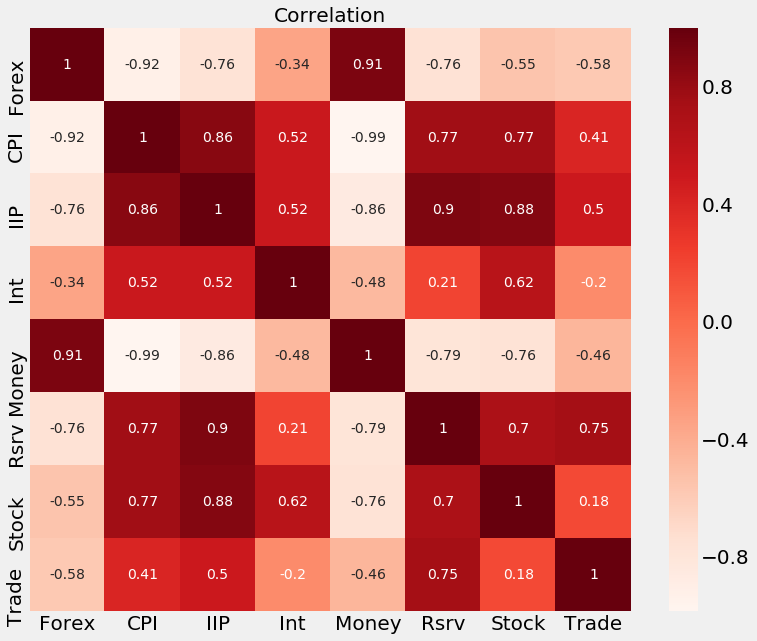

In [745]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
df_corr = df_d.copy()
df_corr.rename(columns = {'forex':'Forex', 'cpi_d':'CPI', 'iip_d':'IIP', 'int_d':'Int', 'm1_d':'Money', 'rsrv_d':'Rsrv',
                         'stock_d':'Stock', 'trade_d':'Trade'},inplace = True)
cor = df_corr.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
#plt.show()
plt.title('Correlation')
plt.savefig('Correlation.png')

# Thank You !